*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# A tour through Lava

This tutorial provides a high-level overview of the Lava user interface to illustrate how to use Lava for building algorithms and applications. 

Please revisit the following tutorials for a deeper dive into the concepts introduced in this tutorial:
1. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb">Installing Lava</a>
2. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb">Processes</a>
3. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb">ProcessModels</a>
4. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb">Execution</a>
5. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial05_connect_processes.ipynb">Connectivity</a>
6. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial06_hierarchical_processes.ipynb">Hierarchical processes</a>
7. <a href="https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial07_remote_memory_access.ipynb">Remote memory access</a>

## Lava Software Stack

<div> 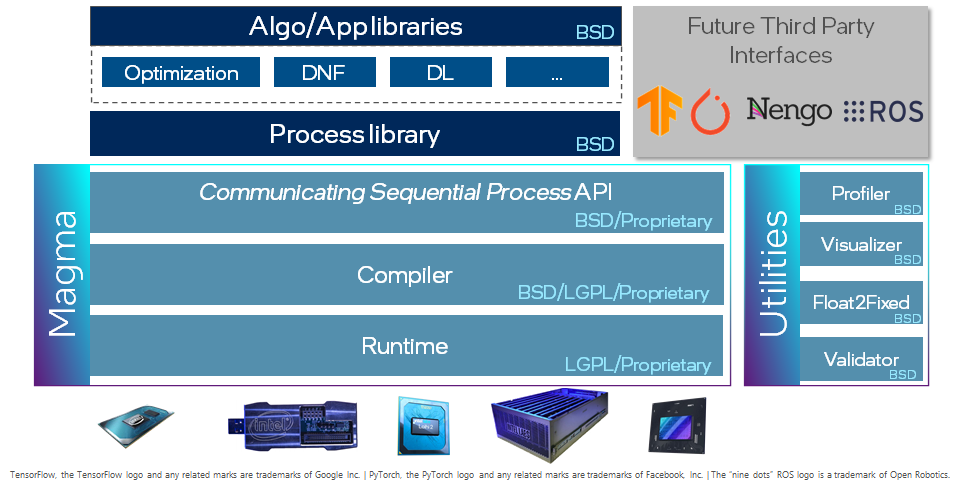 </div>

- Lava has been developed by Intel and primarily supports *Intel Loihi* but it is not meant to be specific to *Loihi* at all!
- Lava is a general programming model for parallel, asynchronous programming; not restricted to spiking neural networks.

## Processes

- Fundamental building block of Lava architecture
- Asynchronous and parallel processes communicate via channels

<div> 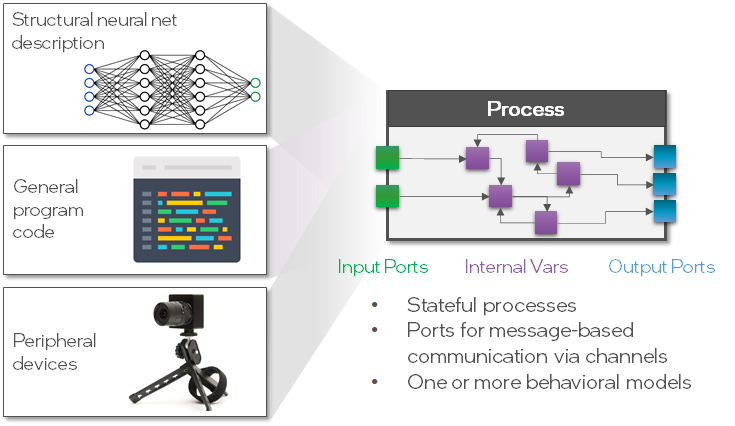 </div>

- Processes are only an interface. Behavioral models are separate!

### Anatomy of a Lava Process

Every `Process` must inherit from `AbstractProcess` or a subclass thereof.

In [ ]:
from lava.magma.core.process.process import AbstractProcess

The simplest `Process` is an empty `Process` without any `Ports`, `Vars` or behavioral models.

In [ ]:
class EmptyProc(AbstractProcess):
    pass

`Processes` show their key attributes when printed. The meaning of these attributes will become clear later.

In [ ]:
print(EmptyProc())

### Processes with Variables and Ports
To create more interesting `Processes`, we need `Vars`...

In [ ]:
from lava.magma.core.process.variable import Var

...and `Ports`. Although there are other types of `Ports`, `InPorts` and `OutPorts` suffice for now.

In [ ]:
from lava.magma.core.process.ports.ports import InPort, OutPort

- A `Process` defines its internal `Vars` and `Ports` in its constructor.
- `Ports` and `Vars` are tensor/array-valued and thus accept a 'shape' argument.
- Vars also accept an initial value 'init'

In [ ]:
class Proc(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (2,))
        # Define ports
        self.inp = InPort(shape=(1,))
        self.out = OutPort(shape=(1,))
        # Define Vars
        self.var1 = Var(shape=shape, init=0)
        self.var2 = Var(shape=shape, init=2)

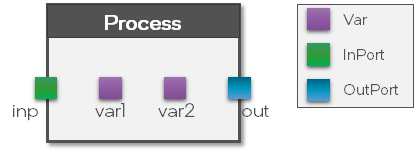

A `Process` is aware of its `Ports` and `Vars`...

In [ ]:
p = Proc(name='NewProc')
print(p)

... so are `Ports` and `Vars` aware of their parent `Process` as well as what they are connected to.

In [ ]:
print(p.inp)
print(p.out)

The initial value assigned to a `Var` is only broadcast to 'shape' at runtime.

In [ ]:
print(p.var1)
print(p.var2)

<div class="alert alert-block alert-info">
<b>Note: </b> The `shareable` attribute controlls whether a Var can be manipulated via remote memory access. Will be covered later.
</div>

The `Vars` and `Ports` of a `Process` can also be accessed via corresponding collections.

In [ ]:
assert(p.vars.var1 == p.var1)
assert(p.in_ports.inp == p.inp)

These collections also provide further information about all the `Ports` and `Vars` of a `Process`.

In [ ]:
print(p.vars.member_names)

In [ ]:
assert(p.out_ports.is_empty == False)

Collections also provide an iterator to selectively iterate over `Process` members (like `Vars`, `InPorts`, ...) of a specific type.

In [ ]:
for v in p.vars:
    print(v)

### Summary
- Lava `Processes` do only define a user interface. 
- The behavioral model that uses `Vars` and `Ports` is defiend separately.
- To ease the interaction with `Processes`, they may have additional non-`Var` attributes or interfacing methods.

Before diving deep into behavioral modelling, let's first understand how to build networks of interconnected `Processes`.

## Ports

`Ports` enable Lava `Proceses` to interact and exchange information with other `Processes` in their environment. 

Lava provides a variety of different `Ports` for different purposes:
<div> 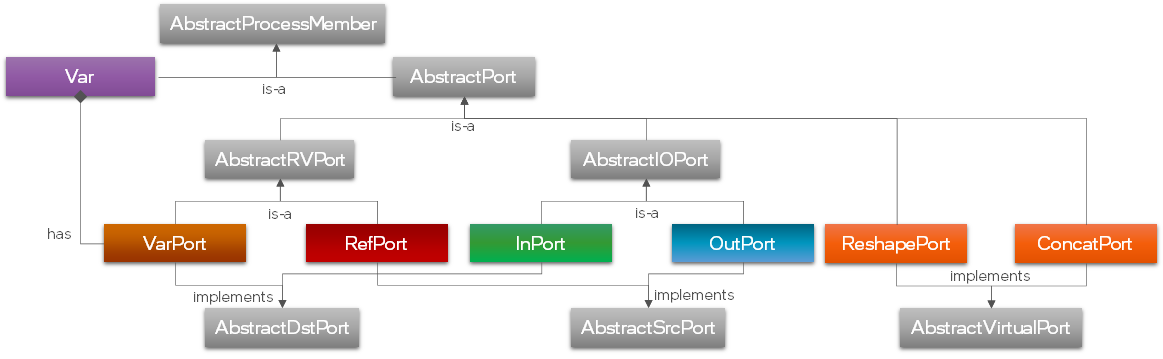 </div>

The following sub sections explain how `Ports` can be used to connect `Processes`. The dynamic aspects of information exchange via `Ports` will be explained as part of behavioral modelling.

### Connecting Lava Processes via InPorts and OutPorts

- `Processes` are self-contained functional units which only act on their own private memory and interact with their environment via asynchronous, event-based message-passing from `OutPorts` to `InPorts` via channels.
- Private state and message-passing provides safety guarantees on memory coherence when dealing with parallel systems.

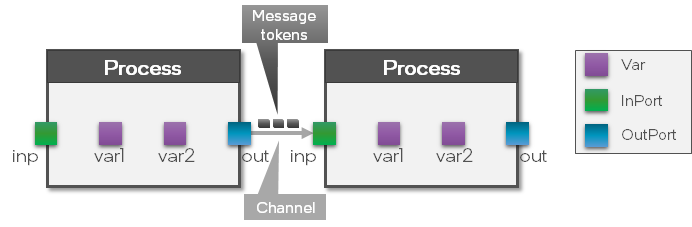

`Processes` connect via their `Ports` (Channels are implicit and only get created at runtime).

In [ ]:
p1 = Proc()
p2 = Proc()
p1.out.connect(p2.inp)

<div class="alert alert-block alert-info">
<b>Note: </b> Only `Ports` with compatible (=identical) shapes can be connected.
</div>

`Ports` are aware of their connections.

In [ ]:
print(p1.out)
print(p2.inp)

<div class="alert alert-block alert-info">
<b>Note: </b> Normally, `OutPorts` only have out_connections while `InPorts` only have in_connections. However, in case of hierarchical `Processes` (discussed later), `InPorts`/`OutPorts` can also have connections to nested `InPorts`/`OutPorts`. Normally, `OutPorts` only have out_connections while `InPorts` only have in_connections. However, in case of hierarchical `Processes` (discussed later), `InPorts`/`OutPorts` can also have connections to nested `InPorts`/`OutPorts`.
</div>

Besides 1:1 connections, Lava supports 1:many connection...

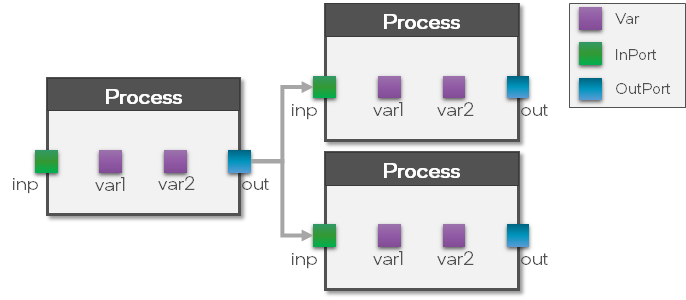

In [ ]:
p3 = Proc()
p4 = Proc()
p5 = Proc()
p3.out.connect([p4.inp, p5.inp])
print(p3.out)
print(p4.inp)
print(p5.inp)

...and many:1 connections.

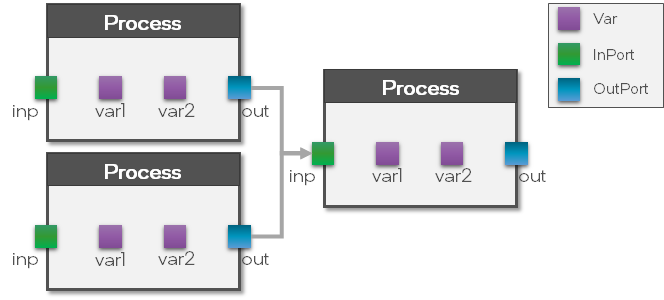

In [ ]:
p6 = Proc()
p7 = Proc()
p8 = Proc()
p6.out.connect(p8.inp)
p7.out.connect(p8.inp)
# Alternative syntax
# p8.inp.connect_from([p6.out, p7.out])
print(p6.out)
print(p7.out)
print(p8.inp)

Finally, the connect() method is additive and supports recurrent connections.

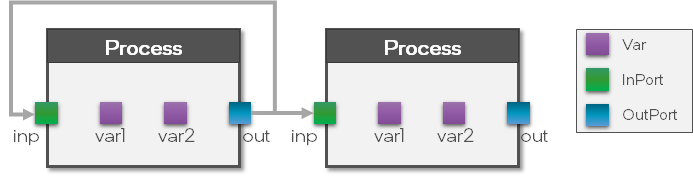

In [ ]:
p9 = Proc()
p10 = Proc()
p9.out.connect(p10.inp)
p9.out.connect(p9.inp)
print(p9.out)
print(p10.inp)

### Remote memory access via RefPorts and VarPorts

- `Processes` only act on their own private memory and interact with other `Processes` via messages.
- Sometimes, we want `Process` A to change the configuration/behavior of `Process` B at runtime (think structural plasticity in a neural network, etc.)
- The behavior of a `Process` is determined by `ProcessModels` discussed below.
- The behavior of a `Process` is affected by incoming messages and its internal state. There are two possible scenarios to change internal state:
    - **Explicit:** `Process` B supports an explicit protocol how its behavior can be altered. In this case, `Process` A may send specific messages to `Process` B via `OutPorts`/`InPorts` to instruct `Process` B how to change its behavior.
    - **Implicit:** `Process` B allows external modifications to its behavior by merely granting `Process` A access to its internal state. Such remote memory access is in principle unsafe and should therefore be used with caution!
    
In Lava, even remote memory access between `Processes` is realized via message-passing to remain true to the overall event-based message passing concept. However, as a convenience feature, Lava provides so-called `RefPorts` and `VarPorts` to syntactically simplify the act of interacting with remote `Vars`.

Two minimalistic `Processes` are sufficicient to demonstrate remote memory access:

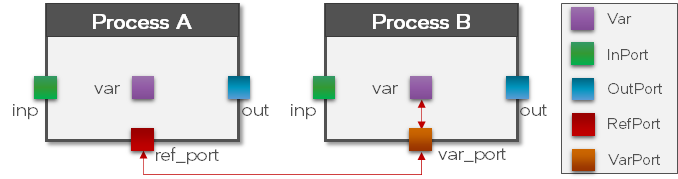

The `ports` package gives access to `RefPorts` and `VarPorts`.

In [ ]:
from lava.magma.core.process.ports.ports import RefPort, VarPort

`Process` A may have a `RefPort` besides other `Vars` and `InPorts`/`OutPorts` (not shown for clarity)...

In [ ]:
class ProcA(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ref_port = RefPort(shape=(1,))

...while `Process` B may have a `VarPort` to explicitly expose an internal `Var` to external `Process` for remote memory access. To associate a `Var` with a `VarPort`, it is passed as an argument to the `VarPort` constructor.

In [ ]:
class ProcB(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.referenced_var = Var(shape=(1,))
        self.var_port = VarPort(var=self.referenced_var)

`RefPorts` connect to `VarPorts` just like `OutPorts` connect to `InPorts`.

In [ ]:
a = ProcA()
b = ProcB()
a.ref_port.connect(b.var_port)

<div class="alert alert-block alert-info">
<b>Note: </b> The name `RefPort` alludes to the fact, that information is effectively exchanged between `Process` B and A via reference. In contrast, `OutPorts`/`InPorts` exchange information by value.
</div>
<div class="alert alert-block alert-info">
<b>Note: </b> `OutPorts`-`VarPorts` and `RefPorts`-`InPorts` do not connect.
</div>

Similar to `OutPorts`/`InPorts`, `Processes` are aware of these `Ports`...

In [ ]:
print(a)
print(b)

...and so are the `RefPorts` of their `Processes` and connections.

In [ ]:
print(a.ref_port)
print(b.var_port)
print(b.referenced_var)

<div class="alert alert-block alert-info">
<b>Note: </b> `Var.shareable` must be True for another `RefPort` to connect to it.
</div>

Creating explicit `VarPorts` can be cumbersome. It is useful to signal that a Var is expected to be manipulated externally. But often a `Process` might not be aware of which of its internal `Vars` another `Process` might want to access. Therefore, `VarPorts` can also be created implicitly.

In [ ]:
aa = ProcA()
bb = ProcB()
aa.ref_port.connect_var(bb.referenced_var)

As a result, the `bb` instance of `ProcB`, now also has an implicitly created `VarPort`.

In [ ]:
print(aa.ref_port)
for p in bb.var_ports:
    print(p)

<div class="alert alert-block alert-info">
<b>Note: </b> How Vars and all the different `Ports` types are actually used for message-passing will be explained as part of behavioral modelling.
</div>

In [ ]:
# Clear all variables introduced so far for demo purposes
# %reset -f

## ProcessModels

- Lava `Processes` only define an interface in terms of `Vars`, `Ports` and other interfacing methods.
- `ProcessModels` are separate classes providing behavioral implementations for a specific `Process`.
- There are two categories of `ProcesModels`:
    - **`SubProcessModels`**:
        - Define `Process` behavior in terms of other sub-`Processes`.
        - `Process` refinement can be applied recursively: `Processes` of `Processes`.
        - Hierarchical `Process` implementations correspond to a tree structure.
    - **`LeafProcessModels`**:
        - Found at the leaves of a `Process` tree/hierarchy.
        - Define `Process` behavior directly in terms of executable code or for instance as a structural definition of a neural network.

<div> 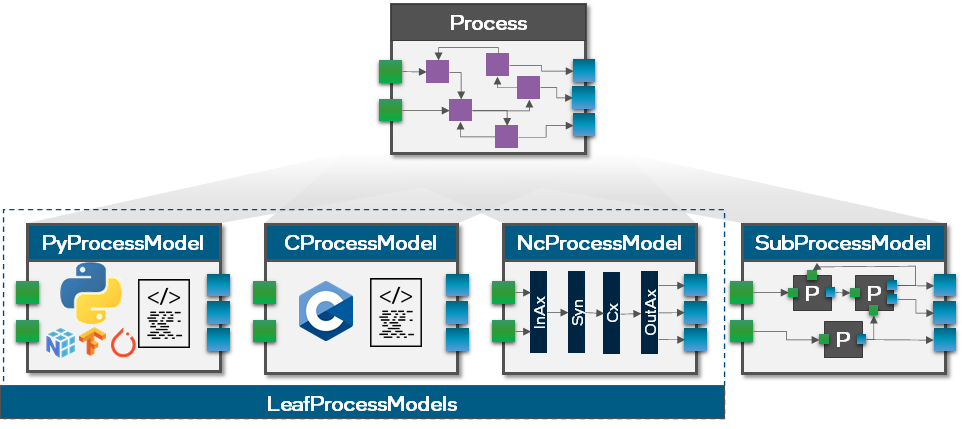 </div>

To understand these basic concepts, let's first take a closer look at only `PyProcessModels` and `SubProcessModels`.

### PyProcessModels

The most transparent and easiest to understand `ProcessModel` is the `PyProcessModel` which implements a `Process` as well as its `Vars` and `Ports` as executable Python code.

#### Process definition
As a first step, we create a new minimal `Process` with one `InPort`, `Var` and `OutPort`.

In [ ]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

class LeafProc(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.inp = InPort(shape=(1,))
        self.out = OutPort(shape=(1,))
        self.var = Var(shape=(1,), init=1)

#### PyProcessModel definition
A new Python-based `ProcessModel` must inheric from `AbstractPyProcesModel`.

In [ ]:
from lava.magma.core.model.py.model import AbstractPyProcessModel

In addition, the implementation of a Lava `InPort`, `OutPort` or `Var` requires `PyPorts` and `LavaPyType` classes.

In [ ]:
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType

Furthermore, the definition of a `PyProcessModel` requires the `implements` and `requires` decortors:
- `implements` specifies which Lava `Process` a `ProcessModel` provides the implementation for. Optionally, the `implements` decorator also specifies which `SyncProcotol` a `ProcessModel` implements (more about this later).
- `requires` specifies which `ComputeResource` a `ProcessModel` requires. In this case a `CPU`.

In [ ]:
from lava.magma.core.decorator import implements, requires
from lava.magma.core.resources import CPU

This allows to finally, define the `ProcessModel` implementing the `Process` *Proc*:
- The `implements` decorator makes the `ProcessModels` discoverable by the compiler and to associate it with the right `Process`.
- The `requires` decorator provides further hints to the compiler allowing it to select the right out of several `ProcessModels`.
- `LavaPyTypes` specify the data structure and numeric data type to implement the `Ports` and `Vars` declared in the `Process`. In addition, `LavaPyType` accepts an optional *precision* argument in case of fixed-point arithmetic.
- `LavaPyTypes` are stored as class variables and are usd by the compiler to initialize instance variables for *inp*, *out* and *var*.
- The `__init__(..)` method passes compiler-provided variables to the parent class and may initialize one or more local variables.
- The `run(..)` method is automatically launched by the Lava Runtime at runtime. It implements the behavior of the `ProcessModel` by updating internal state and communicating information via `Ports`.

The following example, simply adds the received value to its internal state (at most twice) and sends the updated variable forward.

In [ ]:
import numpy as np

@implements(proc=LeafProc)
@requires(CPU)
class PyLeafProcModel(AbstractPyProcessModel):
    inp: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    var: np.ndarray = LavaPyType(np.ndarray, float)

    def __init__(self, model_id, name):
        super().__init__(model_id, name)
        self.iteration = 0

    def run(self):
        if self.iteration < 2:
            val = self.inp.recv()
            print(f"Process={self.name}: iter={self.iteration}, var + recv_val = {self.var[0]} + {val[0]} = {self.var[0]+val[0]}")
            self.var[:] += val
            self.out.send(self.var)
            self.iteration += 1

<div class="alert alert-block alert-info">
<b>Note: </b> When writing asynchronous code, be careful to avoid behavior that results in deadlocks. Whenever an `InPort` is connected, but when there is no input, `recv(..)` will block until a message is received. If an InPort is not connected, `recv(..)` returns a *np.zeros* array immediately.
</div>

#### Execution
To demonstrate the execution of a *Proc* using `PyProcModel`, we create three of them and connect them in series.

In [ ]:
# This is a temporary workaround because Python multiprocessing seems to have trouble finding and serializing PyProcModel on Windows defined in prior cell
from lava.tutorials.end_to_end.tutorial00_collateral import LeafProc

p1, p2, p3 = LeafProc(), LeafProc(), LeafProc()
p1.out.connect(p2.inp)
p2.out.connect(p3.inp)

Before a `Process` can be executed via the Lava `Runtime` its `ProcessModel` must be complied by the Lava `Compiler`:
<div> 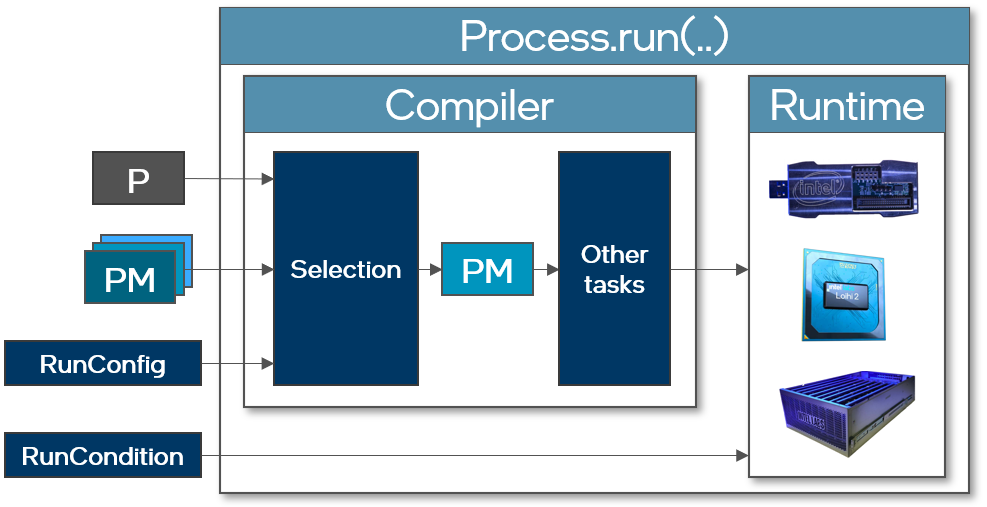 </div>

Generally, there could be one or more `ProcessModels` of the same or differnt types that implement a specific `Process`. For the `Compiler` to decide which `ProcessModel` to chose at compile time, it delegates the selection of a `ProcessModel` to a specific subclass of `RunConfig` which selects one and only one `ProcessModel` per Process based on pre-defined criteria.

In [ ]:
from lava.magma.core.run_configs import RunConfig

Here, we just define a `RunConfig` that simply selects the first `ProcessModel` provided.

In [ ]:
class LeafProcRunCfg(RunConfig):
    def select(self, process, process_models):
        return process_models[0]

<div class="alert alert-block alert-info">
<b>Note: </b> This is just a minimalistic example. More sophisticated `select(..)` methods are possible and Lava provides a set of pre-defiend `RunConfigs`.
</div>

In addition, we must provide the Lava `Runtime` a condition for how long to run a `Process`. Currently Lava offers...
- ...`RunSteps`, which executes a set of `Processes` for a fixed number of algorithmic time steps.
- ...`RunContinuous`, which executes a set of `Processes` continuously until execution is either paused or stopped by the user.

Here, we use `RunContinuous` for simplicity.

In [ ]:
from lava.magma.core.run_conditions import RunContinuous  

To run the set of connected `Processes` p1, p2, and p3, all we need to do is call `run(..)` on any of them. `run(..)` will automatically set up the Lava `Compiler` and `Runtime` behind the scenes to compile and execute the `Processes`.

In [ ]:
print("Running...")
p1.run(condition=RunContinuous(), run_cfg=LeafProcRunCfg())
print(p1)

<div class="alert alert-block alert-info">
<b>Note: </b> `RunContinuous` is non-blocking. It starts execution in one or more parallel asynchronous `Processes` and returns immediately until execution is paused or stopped.
</div>

<div class="alert alert-block alert-info">
<b>Note: </b> All `Processes` are now compiled and have their *proc_model* assigned. `Processes` cannot be compiled twice.
</div>

<div class="alert alert-block alert-info">
<b>Note: </b> Check terminal executing the jupypter server for print output from `PyProcModel`. It is not shown in the output cell above.
</div>

The continuously running `Process` can be paused, i.e. to modify the state of a `Var` from the command line.

In [ ]:
p1.pause()
print(f"p3.var before set(..): {p3.var.get()}")
p3.var.set(np.array([10]))
print(f"p3.var after set(..): {p3.var.get()}")

<div class="alert alert-block alert-info">
<b>Note: </b> Interaction with internal state via `Var.set(..)` or `Var.get()` comes with overhead and should only be used for diagnostic/debug purposes. For efficient communication between `Processes`, use `InPorts`, `OutPorts` or `RefPorts` instead.
</div>

Finally, all the `Processes` can be stopped.

In [ ]:
p1.stop()

<div class="alert alert-block alert-info">
<b>Note: </b> While pausing preserves the state of all `Processes` to resume execution at a later point, stopping does not preserve any state and shuts the `Runtime` down.
</div>

#### Why use Processes and ProcessModels instead of simple inheritance?

`ProcessModels` effectively provide a specific implementation for state and behavior of a `Process`. Often this can be solved with *inheritance* in object-oriented programming. So why introduce separate `ProcessModel` classes and a selection mechanism based on `RunConfigs`?
- **Implementation-agnostic applications**: Application code using `Processes` can remain unaware of the particular behavioral implementation selected at runtime. *Inheritance* would embed a specific implemenation choice in the application code.
- **Platform-agnostic applications**: Behavioral models are not always provided as executable Python code like in `PyProcessModels`. See `CProcessModels` or `NcProcessModels`.
- **Deferred building of ProcessModels**: Lava applications are generally assumed to run on a distributed system of nodes. Thus `ProcessModel` instances are not built immediately but "lazily" on the remote machine.

### SubProcessModels

- `LeafProcessModels` are a way to provide a direct implementation of a `Process`'s behavioral model. 
- In contrast, `SubProcessModels` allow to implement a `Process`'s behavioral model indirectly in terms of other sub-`Processes`.

<div> 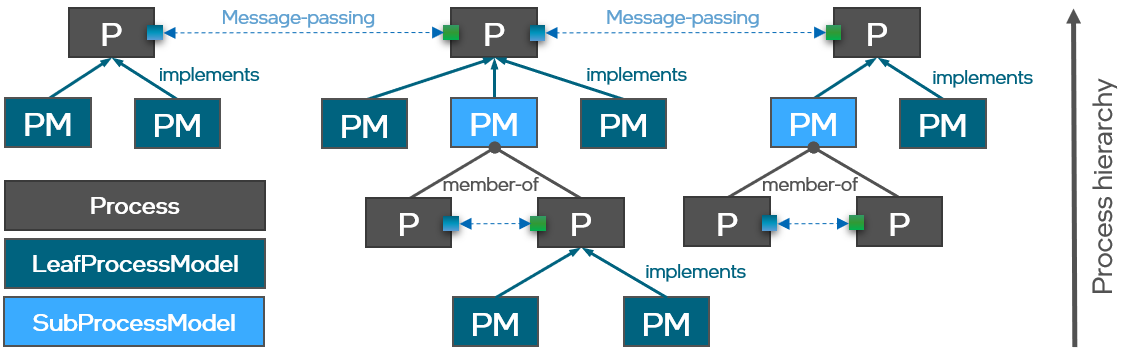 </div>

`SubProcessModels` recursively refine implementation of a `Process` thus defining a hierarchy of `Processes`:
- **Modularity:** Enables to build application from reusable building blocks.
- **Iterative Process refinement:** Co-existance of `LeafProcessModels` and `SubProcessModels` for same `Process` allows to start from high-level behavioral model and iteratively refine a `Process`'s implementation towards a version optimized for a specific hardware platform.

#### Process definition
As a minimal example for how `SubProcessModels` work, we create a new `Process` type, `CompositeProc`, with two inputs to differentiate from the earlier `LeafProc`.

In [ ]:
class CompositeProc(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.inp1 = InPort(shape=(1,))
        self.inp2 = InPort(shape=(1,))
        self.out = OutPort(shape=(1,))
        self.var = Var(shape=(1,), init=1)

#### SubProcessModel definition
New `SubProcessModels` need to inherit from `AbstractSubProcessModel`.

In [ ]:
from lava.magma.core.model.sub.model import AbstractSubProcessModel

Similar to `LeafProcessModels`, `SubProcessModels` expect the `implements` decorator to specify the `Process` it implements. However, neither the `requires` decorator nor the declaration of the `Port` and `Var` are needed compared to a `LeafProcessModel`. Both the `ComputeResources` (like `CPU`) and the `Port`/`Var` implementation are inferred from the sub-`Processes` instantiated inside the `__init__(..)` method.

As part of the `SubProcessModel` constructor, we build a sub-graph of `Processes` by connecting `Processes` to each other and to the `Ports` of the parent `Process`. In addition, internal `Vars` of a sub-`Process` can be exposed at the interface-level of the parent `Process` by defining an alias-relationship between the `Vars` at the parent and sub-`Process` level. Any sub-`Process` used in this example could itself have other `SubProcessModels` implementing it. Hence this hierarchical structure could continue recursively.

<div> 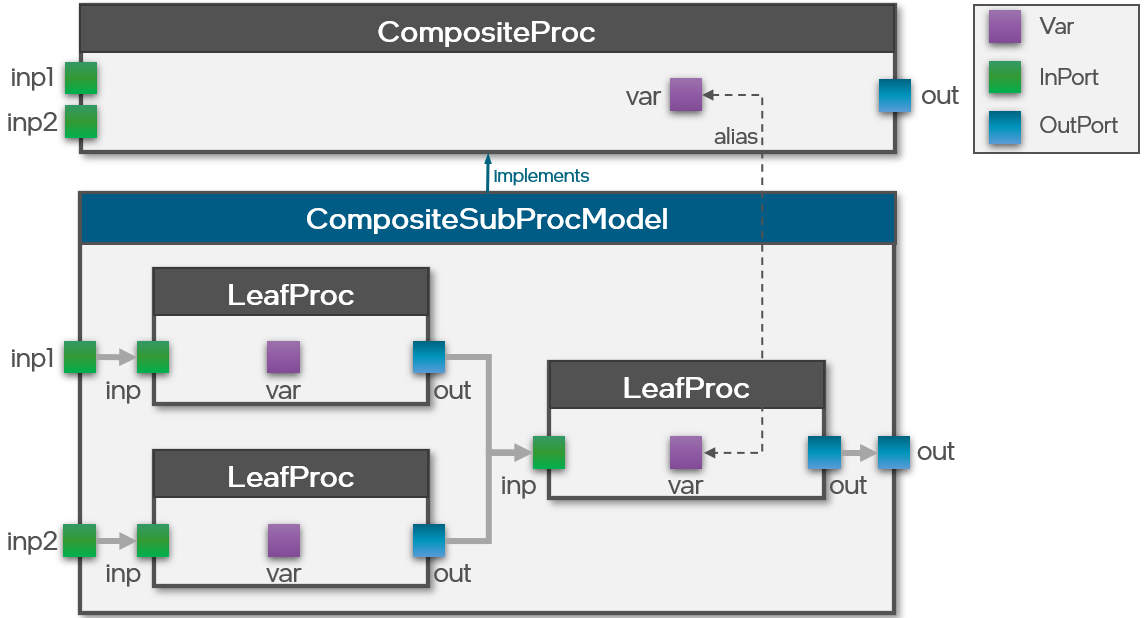 </div>

In [ ]:
@implements(proc=CompositeProc)
class CompositeSubProcModel(AbstractSubProcessModel):
    def __init__(self, proc: CompositeProc):
        super().__init__(proc)
        # Instantiate sub-Processes
        self.proc1 = LeafProc()
        self.proc2 = LeafProc()
        self.proc3 = LeafProc()
        
        # Connect sub-Processes amongst each other
        self.proc3.inp.connect_from([self.proc1.out, self.proc2.out])
        
        # Connect sub-Processes to parent Process
        proc.inp1.connect(self.proc1.inp)
        proc.inp2.connect(self.proc2.inp)
        self.proc3.out.connect(proc.out)
        
        # Expose internal Var of sub-Process
        proc.var.alias(self.proc3.var)

#### Execution

To execute this `Process` are more sophisticated `RunConfig` is needed. For this example, the `CompProcRunCfg` primarily selects a subclass of `AbstractSubProcessModel` when available, otherwise an `AbstractPyProcessModel`.

In [ ]:
class CompProcRunCfg(RunConfig):
    def select(self, process, process_models):
        selected_pm = None
        for pm in process_models:
            if issubclass(pm, AbstractSubProcessModel):
                selected_pm = pm
            elif not selected_pm and issubclass(pm, AbstractPyProcessModel):
                selected_pm = pm
        return selected_pm

Running this hierarchical `Process` results in `LeafProc`1 and 2 receiving no input thus keeping their internal `Vars` constant while `LeafProc` 3 receives and input of 2 twice which adds to 5.

In [ ]:
p = CompositeProc()
p.run(condition=RunContinuous(), run_cfg=CompProcRunCfg())
print("Running...")
import time

time.sleep(3)
p.pause()

print(f"p.var = {p.var.get()} = p.procs.proc3.var = {p.procs.proc3.var.get()}")

p.stop()

<div class="alert alert-block alert-info">
<b>Note: </b> Check terminal executing the jupypter server for print output from `PyProcModel`. It is not shown in the output cell above.
</div>

<div class="alert alert-block alert-info">
<b>Note: </b> p.var aliases p.procs.proc3.var and thus both return the same value.
</div>

### Coming soon: NeuroCoreProcessModels
`NeuroCoreProcessModels` for execution of Processes on Loihi hardware are not yet supported!

Below is a more advanced example of a basic *Leaky-Integrate-and-Fire* `Process`.

In [ ]:
class LIF(AbstractProcess):
    """Leaky-Integrate-and-Fire neural process realizing the following abstract behavior:
    u[t] = u[t-1] * (1-du) + a_in
    v[t] = v[t-1] * (1-dv) + u[t] + b
    s_out = v[t] > vth
    v[t] = v[t] - s_out*vth
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.num_neurons = kwargs.get("num_neurons", 1)
        shape = (self.num_neurons,)
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)
        self.u = Var(shape=shape, init=kwargs.pop("u", 0))
        self.v = Var(shape=shape, init=kwargs.pop("v", 0))
        self.b = Var(shape=shape, init=kwargs.pop("b", 0))
        self.du = Var(shape=(1,), init=kwargs.pop("du", 0))
        self.dv = Var(shape=(1,), init=kwargs.pop("dv", 0))
        self.vth = Var(shape=(1,), init=kwargs.pop("vth", 10))

To execute such a `Process` on Loihi neuromorphic hardware, a structural network description in terms of `InputAxons`, `Synapses`, `DendriticAccumulators`, `Compartments` or `OutputAxons` is required because Loihi does not execute arbitrary instructions.

Key differences compared to `PyProcessModel`:
- No separate `Var` or `Port` implementations are required.
- The `allocate(..)` method allocates structural neural network resources given a `net` object provided by the Lava `Compiler` at compile time. 

The `Net` class allows to create `InputAxons`, `Synapses`, `DendriticAccumulators`, `Compartments` or `OutputAxons`. These objects form a directed graph starting from `InputAxons` to `OutputAxons`. Each of these objects has discrete state associated with e.g. with each `Synapse` or neural `Compartment` like weights or voltages as well as shared configuration state. Both discrete and shared configuration state can be initialized with `Vars` of the parent `Process`.

<div> 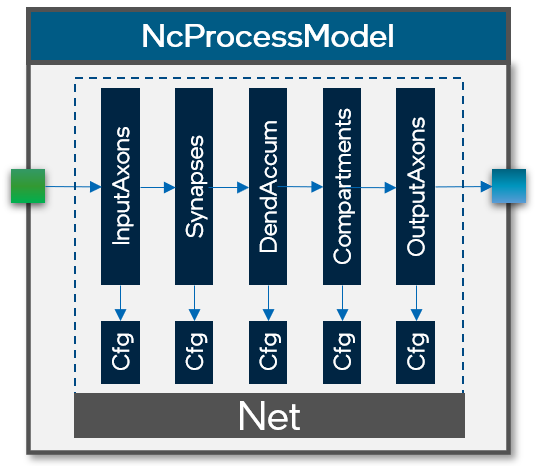 </div>

In [ ]:
from lava.magma.core.resources import Loihi1NeuroCore
from lava.magma.core.model.nc.model import LoihiNcProcessModel

@implements(proc=LIF)
@requires(Loihi1NeuroCore)
class LifNcProcessModel(LoihiNcProcessModel):
    def allocate(self, proc, net):
        """Allocates structural resources in virtual neuro core (net)."""
        # Allocate OutputAxons
        out_ax = net.out_ax.alloc(size=proc.num_neurons)
        
        # Connect OutputAxons to OutPort
        net.connect(out_ax, proc.s_out)
        
        # Allocate shared configuration and discrete Compartment state
        cx_cfg = net.cx_cfg.alloc(size=1,
                                  du=proc.du,
                                  dv=proc.dv,
                                  vth=proc.vth)
        cx = net.cx.alloc(size=proc.num_neurons,
                          u=proc.u,
                          v=proc.v,
                          b_mant=proc.b,
                          cx_cfg=cx_cfg)
        
        # Connect Compartments to OutputAxons
        net.connect(cx, out_ax)
        
        # Allocate DendriticAccumulators
        da = net.da.alloc(size=proc.num_neurons)
        
        # Connect InPort to DendriticAccumulators to Compartments
        net.connect(proc.a_in, da)
        net.connect(da, cx)

<div class="alert alert-block alert-info">
<b>Note: </b> A `Net` effectively represents a "virtual" NeuroCore but with unlimited resources. The `Compiler` will automatically partition the `Net` graph to multiple "physical" NeuroCores, each with limited memory resources.
</div>

### Coming soon: CProcessModels
`CProcessModels` for execution of `ProcessModels` written in C on a generic `CPU` or an embedded CPU `ECPU` are not yet supported!

Lava will also allow to implement `ProcessModels` in the C programming language soon. Such C code can be optionally executed on a regular CPU. However, C code is required for execution on embedded CPUs of the Loihi architecture. In the future, we will also offer to automatically generate embedded C from `PyProcessModels`.

For C execution, we still need a Python `ProcessModel` inheriting from `AbstractCProcessModel`. Similar to `PyProcessModels` it defines the data type and precision of (for fixed-point arithmetic) of the Lava `Vars` and `Ports`. Other than that, it only specifies the file name (within the same directory as the `CProcessModel`) that provides the source code of the `ProcessModel` written in C.

In [ ]:
from lava.magma.core.model.c.model import AbstractCProcessModel
from lava.magma.core.model.c.ports import CInPort, COutPort
from lava.magma.core.model.c.type import LavaCType
from lava.magma.core.resources import ECPU

@implements(proc=LIF)
@requires(ECPU)
class LifCProcessModel(AbstractCProcessModel):
    a_in        = LavaCType('signed short', precision=16, port_type=CInPort)
    s_out       = LavaCType('unsigned char', precision=1, port_type=COutPort)
    u           = LavaCType('int', precision=24)
    v           = LavaCType('int', precision=24)
    b           = LavaCType('int', precision=12)
    du          = LavaCType('unsigned short', precision=12)
    d           = LavaCType('unsigned short', precision=12)
    vth         = LavaCType('unsigned short', precision=16)
    
    @property
    def source_file(self):
        """Returns name of *.c and *.h file with CProcessModel source code."""
        return 'lif_c_process_model'